# Electronic Structure Calculations using Generalized Ising Hamiltonians

Your final task is to calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$$ 
H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j
+ \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k
+ \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l
+ \cdots
$$

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided to you by the `read_generalized_ising_hamiltonian` function below.

These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [1]:
import string
import os
import re

import numpy as np

from abstract_ising import AbstractIsing
from ising_animator import IsingAnimator

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [3]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

First, you must write a class that describes the Generalized Ising Model given the arrays containing the Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration (see the previous tasks for inspiration), as well as a function which computes the change in energy resulting from a single-spin-flip (you could of course use the naive approach and simply compute the energy of two spin configurations and subtract one from the other).

In [4]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters

class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, num_spins, coeffs_dct):
        """
        Because this is generalised ising it doesn't make any sense to think about dimensionality of spin lattice
        Keep spin lattice as 1d to make indexing simpler. Any concept of dimensionality is baked in with the coefficients
        coeffs is dict containing sets of n-local coefficients
        each key of the dict denotes n
        for example: coeffs[2] is a 2d array of all 2-local coefficients
        """
        assert max(coeffs_dct.keys()) <= 26, f"Yeah... maybe you're asking for too much here"
        for locality, coeffs in coeffs_dct.items():
            assert len(coeffs.shape) == locality, f"coefficients for key {locality} should have dimensionality {locality}"
        self.num_spins = num_spins # number of spins
        self.coeffs_dct = coeffs_dct
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1
        
    def energy(self, spins=None):
        spins = self.spins if spins is None else spins
        energy = 0
        for locality, coeffs in coeffs_dct.items():
            if locality == 0:
                energy += coeffs
            else:
                ixs = string.ascii_lowercase[:locality]
                subscripts = ixs + ',' + ','.join(ixs)
                operands = [coeffs] + [spins] * locality
                energy += np.einsum(subscripts, *operands)
        return energy
    
    def energy_diff(self, i):
        self.spins[i] *= -1
        next_energy = self.energy()
        self.spins[i] *= -1
        current_energy = self.energy()
        diff = next_energy - current_energy
        return diff
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        return (np.random.randint(self.num_spins),)

Next you'll run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [5]:
coeffs_dct = {k: v for k, v in enumerate([E0, h, J, K, L])}
ising = GeneralizedIsingModel(4, coeffs_dct)

# perform 1000 MC steps
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=1.0)
    
    if t % 50 == 0:
        print(E)

-0.48557107681859907
0.7256454984385436
-0.4855710768185992
-0.40205193171305936
-0.25924181243352884
-0.33319337985945596
-1.1299047752322906
-0.40205193171305953
-1.1299047752322906
-0.48557107681859923
-0.40205193171305953
-0.48557107681859907
0.39731238040938194
-0.4855710768185992
0.39731238040938194
-0.33319337985945613
-0.25924181243352884
1.144680802606227
-1.1299047752322906
-0.40205193171305936


Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

Minimum energy found by brute force: -1.0457831649744005


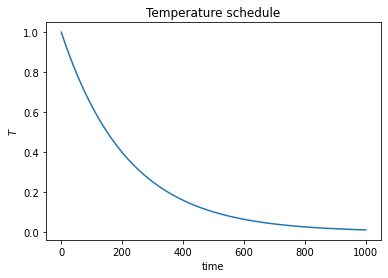

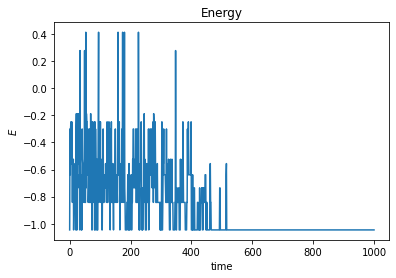

-1.0457831649744005

In [10]:
# BRUTE FORCE CALCULATION
def get_bf_min(ising, return_config=False):
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
    space = 2*space.astype(int) - 1
    energies = []
    for config in space:
        energies.append(ising.energy(config))
    if return_config:
        return min(energies), space[np.argmin(energies)]
    else:
        return min(energies)

def plot_schedule(T):
    t = range(len(T))
    plt.plot(t, T)
    plt.title("Temperature schedule")
    plt.ylabel("$T$")
    plt.xlabel("time");
    plt.show()

# this is for all static annealing schedules
def create_fixed_schedule(num_steps, T_i, T_f=1.0, form='const', cycle={}, show=True):
    """
    we found linear decay is quite useless
    also experimented with adding a exp(sin(t)) multiplier onto the baseline schedule
    """
    implemented = [
        'const', # constant
        'exp', # exponential decay
        'lin', # linear decay
    ]
    assert form in implemented, f"form='{form}' not implemented"
    t = np.arange(num_steps+1)
    if form == 'const':
        T = [T_i] * num_steps
    elif form == 'exp':
        T = T_i * ((T_f/T_i) ** (t/num_steps))
    elif form == 'lin':
        T = T_i + (T_f - T_i) * (t/num_steps)
    if len(cycle):
        amp = cycle['amp']
        period = cycle['p']
        cyc = amp * np.sin(2*np.pi*np.arange(len(T))/period)
        T = T * np.exp(cyc)
    if show:
        plot_schedule(T)
    return T

def plot_energy(Es):
    plt.plot(Es)
    plt.title("Energy")
    plt.ylabel("$E$")
    plt.xlabel("time");
    plt.show()

    
def run_mc(ising, num_steps, T, verbose=False, do_plot=False):
    """
    Runs MC with a static T schedule
    """
    Es = []
    for t in range(num_steps):
        E = ising.mc_step(T=T[t])
        Es.append(E)
        if verbose and t % 100 == 0:
            print(E)
    if do_plot:
        plot_energy(Es)
    if verbose:
        print(f"Minimum energy found by MC: {min(Es)}")
    return min(Es)

bf_min = get_bf_min(ising)
print(f"Minimum energy found by brute force: {bf_min}")
T = create_fixed_schedule(1000, T_i=1, T_f=0.01, form='exp')
run_mc(ising, len(T), T, do_plot=True)

Finally, iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [7]:
# already did this above

Now, clean up your code a little, and write a for-loop that iterates over all the different values of the Hydrogen seperation distance $R$ available in the `hamiltonians` directory. 

For each $R$ you must:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy
- Compare the two results

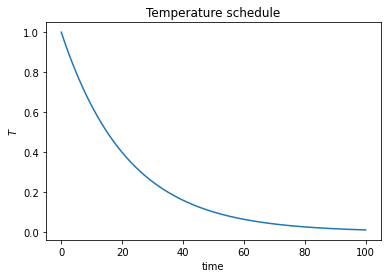

Radii: [0.65, 0.8, 0.95, 1.1, 1.25, 1.4, 1.55, 1.7, 1.85, 2.0, 2.15, 2.3, 2.45, 2.6, 2.75, 2.9, 3.05, 3.2, 3.35, 3.5]


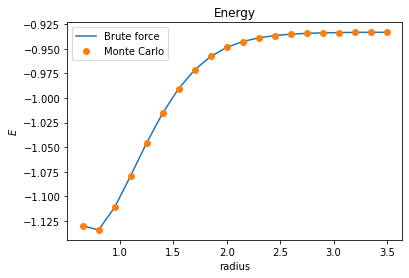

In [11]:
# get ranges from filenames

# T schedule
T = create_fixed_schedule(100, T_i=1, T_f=0.01, form='exp')

Rs = [] # radii
bf_mins = [] # minimum energies found in brute force evaluations
mc_mins = [] # minimum energies found in MC evaluations

for fp in os.listdir('hamiltonians'):
    if 'inp' not in fp:
        continue
    R = re.search('=([0-9,\.]+)\.inp', fp).group(1)
    Rs.append(float(R))
    E0, h, J, K, L = read_generalized_ising_hamiltonian(f"./hamiltonians/Ising-H2-STO-3G-bk-samespin-R={R}.inp")
    coeffs_dct = {k: v for k, v in enumerate([E0, h, J, K, L])}
    ising = GeneralizedIsingModel(4, coeffs_dct)
    bf_mins.append(get_bf_min(ising))
    mc_mins.append(run_mc(ising, len(T), T))

# plotting
bf_mins = [x for _, x in sorted(zip(Rs, bf_mins))]
mc_mins = [x for _, x in sorted(zip(Rs, mc_mins))]
Rs = sorted(Rs)
print(f'Radii: {Rs}')
plt.plot(Rs, bf_mins)
plt.plot(Rs, mc_mins, 'o')
plt.title("Energy")
plt.ylabel("$E$")
plt.xlabel("radius");
plt.legend(['Brute force', 'Monte Carlo'])
plt.show()

## Working with 2-local version

In [12]:
from quantum_H2_ising import GroundStateEnergy

# GroundStateEnergy is a class from Task 1 which, among other things, returns 2-local qubo coefficients
H2 = GroundStateEnergy('H2_coefficients_exact_simulated.csv')
Rs_2 = H2.get_available_R()

[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05, 3.1]


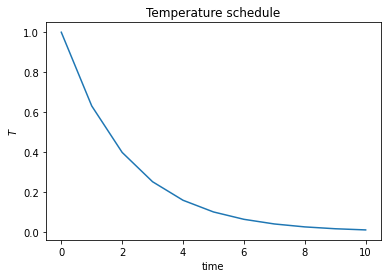

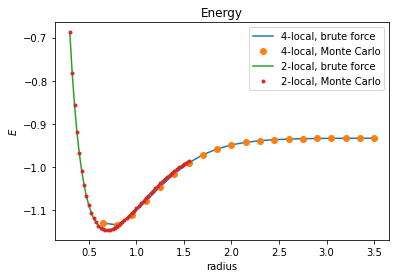

In [22]:
T = create_fixed_schedule(10, T_i=1, T_f=0.01, form='exp')

bf_mins_2 = []
mc_mins_2 = []

for R in Rs_2:
    q_values = H2.get_qubo_coeffs(R)
    # ising coeffs {'a': c_a, 'b': c_a}, {('a', 'b'): c_b}
    h = np.array([q_values['c_a'], q_values['c_a']])
    J = np.array([[0, q_values['c_b']], [0, 0]])
    coeffs_dct = {1: h, 2: J}
    ising = GeneralizedIsingModel(2, coeffs_dct)
    _, bf_min_spins = get_bf_min(ising, return_config=True)
    bf_min = H2.get_energy_from_ising_spins(R, *bf_min_spins)
    bf_mins_2.append(bf_min)
    run_mc(ising, len(T), T)
    mc_mins_2.append(H2.get_energy_from_ising_spins(R, *ising.spins))

# map Rs_2 to half width to match with RsAs
Rs_2 = list(map(lambda x: x/2, Rs_2))
    
# plotting
plt.plot(Rs, bf_mins)
plt.plot(Rs, mc_mins, 'o')
plt.plot(Rs_2, bf_mins_2)
plt.plot(Rs_2, mc_mins_2, '.')
plt.title("Energy")
plt.ylabel("$E$")
plt.xlabel("radius");
plt.legend(['4-local, brute force', '4-local, Monte Carlo', '2-local, brute force', '2-local, Monte Carlo'])
plt.show()